1.Import and Install Dependencies

In [1]:
!pip install tensorflow==2.5.0 tensorflow-gpu==2.5.0 opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2.Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic#Holistic Model
mp_drawing = mp.solutions.drawing_utils#Drawing Utilities

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#Color Coversion
    image.flags.writeable = False                 #Image no longer Writeable
    results = model.process(image)                #Make Prediction
    image.flags.writeable = True                  #Image Writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)#Color Conversion
    return image,results

In [4]:
def draw_landmarks(image, results):
    #Draw Face Connections(Function FACE_Connections has been replaced with FACEMESH_TESSLATION)
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    #Draw Face OutlInes
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    #Draw Pose Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    #Draw Left Hand Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    #Draw Right Hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    #Draw Face OutlInes
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    #Draw Pose Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    #Draw Left Hand Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    #Draw Right Hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [6]:
cap = cv2.VideoCapture(0)
#Set MediaPipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Read Feed
        ret, frame = cap.read()
        #Make Detection
        image, results = mediapipe_detection(frame, holistic)
        #Draw Landmarks
        draw_styled_landmarks(image, results)
        #Show Screen
        cv2.imshow('Maurj Feed', image)
        #Break window
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

3.Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

4.Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [94]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('New_MP_Data') 

# Actions that we try to detect
actions = np.array(['yes', 'no', 'maybe'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [8]:
for action in actions: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5.Collect Keypoint Sequences

In [96]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [93]:
cap.release()
cv2.destroyAllWindows()

6.Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
X = np.array(sequences)

In [14]:
y = to_categorical(labels).astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

7.Build and Train LSTM Neural Network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [17]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
#model.fit(X_train, y_train, epochs=759, callbacks=[tb_callback])
history = model.fit(X_train, y_train, epochs=759, validation_split=0.2)

Epoch 1/759
3/3 [==============================] - 4s 367ms/step - loss: 16.6089 - categorical_accuracy: 0.3529 - val_loss: 1.1912 - val_categorical_accuracy: 0.2941
Epoch 2/759
3/3 [==============================] - 0s 88ms/step - loss: 1.2141 - categorical_accuracy: 0.3382 - val_loss: 2.1674 - val_categorical_accuracy: 0.2941
Epoch 3/759
3/3 [==============================] - 0s 87ms/step - loss: 1.6172 - categorical_accuracy: 0.3088 - val_loss: 2.1075 - val_categorical_accuracy: 0.5294
Epoch 4/759
3/3 [==============================] - 0s 84ms/step - loss: 1.7330 - categorical_accuracy: 0.3971 - val_loss: 1.1815 - val_categorical_accuracy: 0.2941
Epoch 5/759
3/3 [==============================] - 0s 85ms/step - loss: 1.1736 - categorical_accuracy: 0.2500 - val_loss: 1.1903 - val_categorical_accuracy: 0.3529
Epoch 6/759
3/3 [==============================] - 0s 87ms/step - loss: 1.0902 - categorical_accuracy: 0.4706 - val_loss: 1.1864 - val_categorical_accuracy: 0.2941
Epoch 7/759
3/

3/3 [==============================] - 0s 92ms/step - loss: 0.6859 - categorical_accuracy: 0.7647 - val_loss: 0.7703 - val_categorical_accuracy: 0.9412
Epoch 100/759
3/3 [==============================] - 0s 90ms/step - loss: 0.6675 - categorical_accuracy: 0.8529 - val_loss: 0.7296 - val_categorical_accuracy: 0.6471
Epoch 101/759
3/3 [==============================] - 0s 86ms/step - loss: 0.6268 - categorical_accuracy: 0.7353 - val_loss: 0.7512 - val_categorical_accuracy: 0.8235
Epoch 102/759
3/3 [==============================] - 0s 89ms/step - loss: 0.7204 - categorical_accuracy: 0.7794 - val_loss: 0.8108 - val_categorical_accuracy: 0.9412
Epoch 103/759
3/3 [==============================] - 0s 93ms/step - loss: 0.7230 - categorical_accuracy: 0.7647 - val_loss: 0.8739 - val_categorical_accuracy: 0.8235
Epoch 104/759
3/3 [==============================] - 0s 91ms/step - loss: 0.7813 - categorical_accuracy: 0.7794 - val_loss: 0.8073 - val_categorical_accuracy: 0.5882
Epoch 105/759
3/3 

3/3 [==============================] - 0s 88ms/step - loss: 1.0736 - categorical_accuracy: 0.4412 - val_loss: 1.0204 - val_categorical_accuracy: 0.4118
Epoch 198/759
3/3 [==============================] - 0s 87ms/step - loss: 1.0656 - categorical_accuracy: 0.4265 - val_loss: 1.0130 - val_categorical_accuracy: 0.4118
Epoch 199/759
3/3 [==============================] - 0s 90ms/step - loss: 1.0603 - categorical_accuracy: 0.4265 - val_loss: 1.0083 - val_categorical_accuracy: 0.4118
Epoch 200/759
3/3 [==============================] - 0s 94ms/step - loss: 1.0553 - categorical_accuracy: 0.4265 - val_loss: 0.9895 - val_categorical_accuracy: 0.4118
Epoch 201/759
3/3 [==============================] - 0s 100ms/step - loss: 1.0498 - categorical_accuracy: 0.4265 - val_loss: 0.9745 - val_categorical_accuracy: 0.4118
Epoch 202/759
3/3 [==============================] - 0s 98ms/step - loss: 1.0573 - categorical_accuracy: 0.4265 - val_loss: 0.9647 - val_categorical_accuracy: 0.4118
Epoch 203/759
3/3

3/3 [==============================] - 0s 95ms/step - loss: 1.0328 - categorical_accuracy: 0.4853 - val_loss: 1.0131 - val_categorical_accuracy: 0.4706
Epoch 296/759
3/3 [==============================] - 0s 92ms/step - loss: 1.0374 - categorical_accuracy: 0.5147 - val_loss: 1.0047 - val_categorical_accuracy: 0.4706
Epoch 297/759
3/3 [==============================] - 0s 92ms/step - loss: 1.0377 - categorical_accuracy: 0.4559 - val_loss: 1.0000 - val_categorical_accuracy: 0.4706
Epoch 298/759
3/3 [==============================] - 0s 94ms/step - loss: 1.0479 - categorical_accuracy: 0.4559 - val_loss: 0.9980 - val_categorical_accuracy: 0.4706
Epoch 299/759
3/3 [==============================] - 0s 85ms/step - loss: 1.0566 - categorical_accuracy: 0.4559 - val_loss: 0.9953 - val_categorical_accuracy: 0.4706
Epoch 300/759
3/3 [==============================] - 0s 85ms/step - loss: 1.0580 - categorical_accuracy: 0.4559 - val_loss: 0.9909 - val_categorical_accuracy: 0.4706
Epoch 301/759
3/3 

3/3 [==============================] - 0s 99ms/step - loss: 1.0960 - categorical_accuracy: 0.3971 - val_loss: 1.0059 - val_categorical_accuracy: 0.4706
Epoch 394/759
3/3 [==============================] - 0s 88ms/step - loss: 1.1072 - categorical_accuracy: 0.3824 - val_loss: 1.0476 - val_categorical_accuracy: 0.4118
Epoch 395/759
3/3 [==============================] - 0s 89ms/step - loss: 1.1078 - categorical_accuracy: 0.3824 - val_loss: 1.0491 - val_categorical_accuracy: 0.4118
Epoch 396/759
3/3 [==============================] - 0s 99ms/step - loss: 1.1166 - categorical_accuracy: 0.3676 - val_loss: 1.0498 - val_categorical_accuracy: 0.4118
Epoch 397/759
3/3 [==============================] - 0s 113ms/step - loss: 1.1153 - categorical_accuracy: 0.3676 - val_loss: 1.0499 - val_categorical_accuracy: 0.4118
Epoch 398/759
3/3 [==============================] - 0s 96ms/step - loss: 1.1138 - categorical_accuracy: 0.3676 - val_loss: 1.0492 - val_categorical_accuracy: 0.4118
Epoch 399/759
3/3

3/3 [==============================] - 0s 91ms/step - loss: 0.9193 - categorical_accuracy: 0.5882 - val_loss: 0.8807 - val_categorical_accuracy: 0.5294
Epoch 492/759
3/3 [==============================] - 0s 87ms/step - loss: 0.9245 - categorical_accuracy: 0.6029 - val_loss: 0.8797 - val_categorical_accuracy: 0.5294
Epoch 493/759
3/3 [==============================] - 0s 92ms/step - loss: 0.9157 - categorical_accuracy: 0.5735 - val_loss: 0.8957 - val_categorical_accuracy: 0.5294
Epoch 494/759
3/3 [==============================] - 0s 87ms/step - loss: 0.9187 - categorical_accuracy: 0.5441 - val_loss: 0.8552 - val_categorical_accuracy: 0.5294
Epoch 495/759
3/3 [==============================] - 0s 88ms/step - loss: 0.8780 - categorical_accuracy: 0.6029 - val_loss: 0.8296 - val_categorical_accuracy: 0.5882
Epoch 496/759
3/3 [==============================] - 0s 86ms/step - loss: 0.8592 - categorical_accuracy: 0.6029 - val_loss: 0.8670 - val_categorical_accuracy: 0.4706
Epoch 497/759
3/3 

3/3 [==============================] - 0s 93ms/step - loss: 0.6328 - categorical_accuracy: 0.6912 - val_loss: 0.7139 - val_categorical_accuracy: 0.5882
Epoch 590/759
3/3 [==============================] - 0s 92ms/step - loss: 0.6354 - categorical_accuracy: 0.6765 - val_loss: 0.6954 - val_categorical_accuracy: 0.5882
Epoch 591/759
3/3 [==============================] - 0s 88ms/step - loss: 0.6297 - categorical_accuracy: 0.7206 - val_loss: 0.6704 - val_categorical_accuracy: 0.5882
Epoch 592/759
3/3 [==============================] - 0s 86ms/step - loss: 0.6247 - categorical_accuracy: 0.6912 - val_loss: 0.6910 - val_categorical_accuracy: 0.5882
Epoch 593/759
3/3 [==============================] - 0s 90ms/step - loss: 0.6190 - categorical_accuracy: 0.6912 - val_loss: 0.6668 - val_categorical_accuracy: 0.5882
Epoch 594/759
3/3 [==============================] - 0s 87ms/step - loss: 0.6181 - categorical_accuracy: 0.6912 - val_loss: 0.7116 - val_categorical_accuracy: 0.5882
Epoch 595/759
3/3 

3/3 [==============================] - 0s 93ms/step - loss: 0.8926 - categorical_accuracy: 0.6912 - val_loss: 0.8996 - val_categorical_accuracy: 0.5882
Epoch 688/759
3/3 [==============================] - 0s 90ms/step - loss: 0.8701 - categorical_accuracy: 0.6029 - val_loss: 0.9494 - val_categorical_accuracy: 0.4118
Epoch 689/759
3/3 [==============================] - 0s 98ms/step - loss: 0.8627 - categorical_accuracy: 0.5882 - val_loss: 0.8605 - val_categorical_accuracy: 0.5882
Epoch 690/759
3/3 [==============================] - 0s 106ms/step - loss: 0.8275 - categorical_accuracy: 0.7206 - val_loss: 0.8433 - val_categorical_accuracy: 0.4706
Epoch 691/759
3/3 [==============================] - 0s 107ms/step - loss: 0.8133 - categorical_accuracy: 0.6471 - val_loss: 0.8216 - val_categorical_accuracy: 0.7059
Epoch 692/759
3/3 [==============================] - 0s 92ms/step - loss: 0.8103 - categorical_accuracy: 0.8088 - val_loss: 0.8146 - val_categorical_accuracy: 0.7059
Epoch 693/759
3/

In [108]:
history = model.fit(X_train, y_train, validation_split=0.4, epochs=150, batch_size=10)

Epoch 1/150
6/6 [==============================] - 1s 90ms/step - loss: 1.1254 - categorical_accuracy: 0.3333 - val_loss: 1.1046 - val_categorical_accuracy: 0.2941
Epoch 2/150
6/6 [==============================] - 0s 85ms/step - loss: 1.1235 - categorical_accuracy: 0.3333 - val_loss: 1.1024 - val_categorical_accuracy: 0.2941
Epoch 3/150
6/6 [==============================] - 0s 86ms/step - loss: 1.1213 - categorical_accuracy: 0.3333 - val_loss: 1.1016 - val_categorical_accuracy: 0.2941
Epoch 4/150
6/6 [==============================] - 1s 95ms/step - loss: 1.1200 - categorical_accuracy: 0.3333 - val_loss: 1.1016 - val_categorical_accuracy: 0.2941
Epoch 5/150
6/6 [==============================] - 0s 76ms/step - loss: 1.1194 - categorical_accuracy: 0.3333 - val_loss: 1.1018 - val_categorical_accuracy: 0.2941
Epoch 6/150
6/6 [==============================] - 0s 80ms/step - loss: 1.1174 - categorical_accuracy: 0.3333 - val_loss: 1.1007 - val_categorical_accuracy: 0.2941
Epoch 7/150
6/6 

Epoch 51/150
6/6 [==============================] - 0s 85ms/step - loss: 1.0985 - categorical_accuracy: 0.3333 - val_loss: 1.1021 - val_categorical_accuracy: 0.2941
Epoch 52/150
6/6 [==============================] - 0s 85ms/step - loss: 1.0982 - categorical_accuracy: 0.3333 - val_loss: 1.1025 - val_categorical_accuracy: 0.2941
Epoch 53/150
6/6 [==============================] - 0s 84ms/step - loss: 1.0983 - categorical_accuracy: 0.3333 - val_loss: 1.1030 - val_categorical_accuracy: 0.2941
Epoch 54/150
6/6 [==============================] - 1s 96ms/step - loss: 1.0985 - categorical_accuracy: 0.3333 - val_loss: 1.1035 - val_categorical_accuracy: 0.2941
Epoch 55/150
6/6 [==============================] - 1s 96ms/step - loss: 1.0984 - categorical_accuracy: 0.3333 - val_loss: 1.1038 - val_categorical_accuracy: 0.2941
Epoch 56/150
6/6 [==============================] - 1s 93ms/step - loss: 1.0980 - categorical_accuracy: 0.3333 - val_loss: 1.1041 - val_categorical_accuracy: 0.2941
Epoch 57/1

6/6 [==============================] - 1s 89ms/step - loss: 1.0980 - categorical_accuracy: 0.3529 - val_loss: 1.1086 - val_categorical_accuracy: 0.2941
Epoch 150/150
6/6 [==============================] - 0s 86ms/step - loss: 1.0981 - categorical_accuracy: 0.3529 - val_loss: 1.1090 - val_categorical_accuracy: 0.2941


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

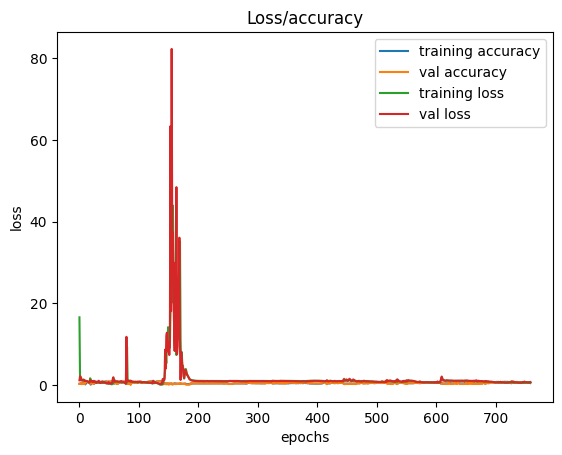

In [29]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['categorical_accuracy'], label='training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss/accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

8.Make Predictions

In [30]:
res = model.predict(X_test)

In [31]:
actions[np.argmax(res[4])]

'iloveyou'

In [32]:
actions[np.argmax(res[4])]

'iloveyou'

9.Save Weights

In [33]:
#First save
model.save('action.h5')

In [32]:
#Delete Model
del model

In [42]:
#Reload an existing model
model.load_weights('action.h5')

10.Evaluation using Confusion Matrix and Accuracy

In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [35]:
yhat = model.predict(X_test)

In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [3, 1]],

       [[4, 0],
        [0, 1]],

       [[2, 3],
        [0, 0]]], dtype=int64)

In [38]:
accuracy_score(ytrue, yhat)

0.4

11.Test in Real Time

In [39]:
from scipy import stats

In [40]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [43]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Maurj Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

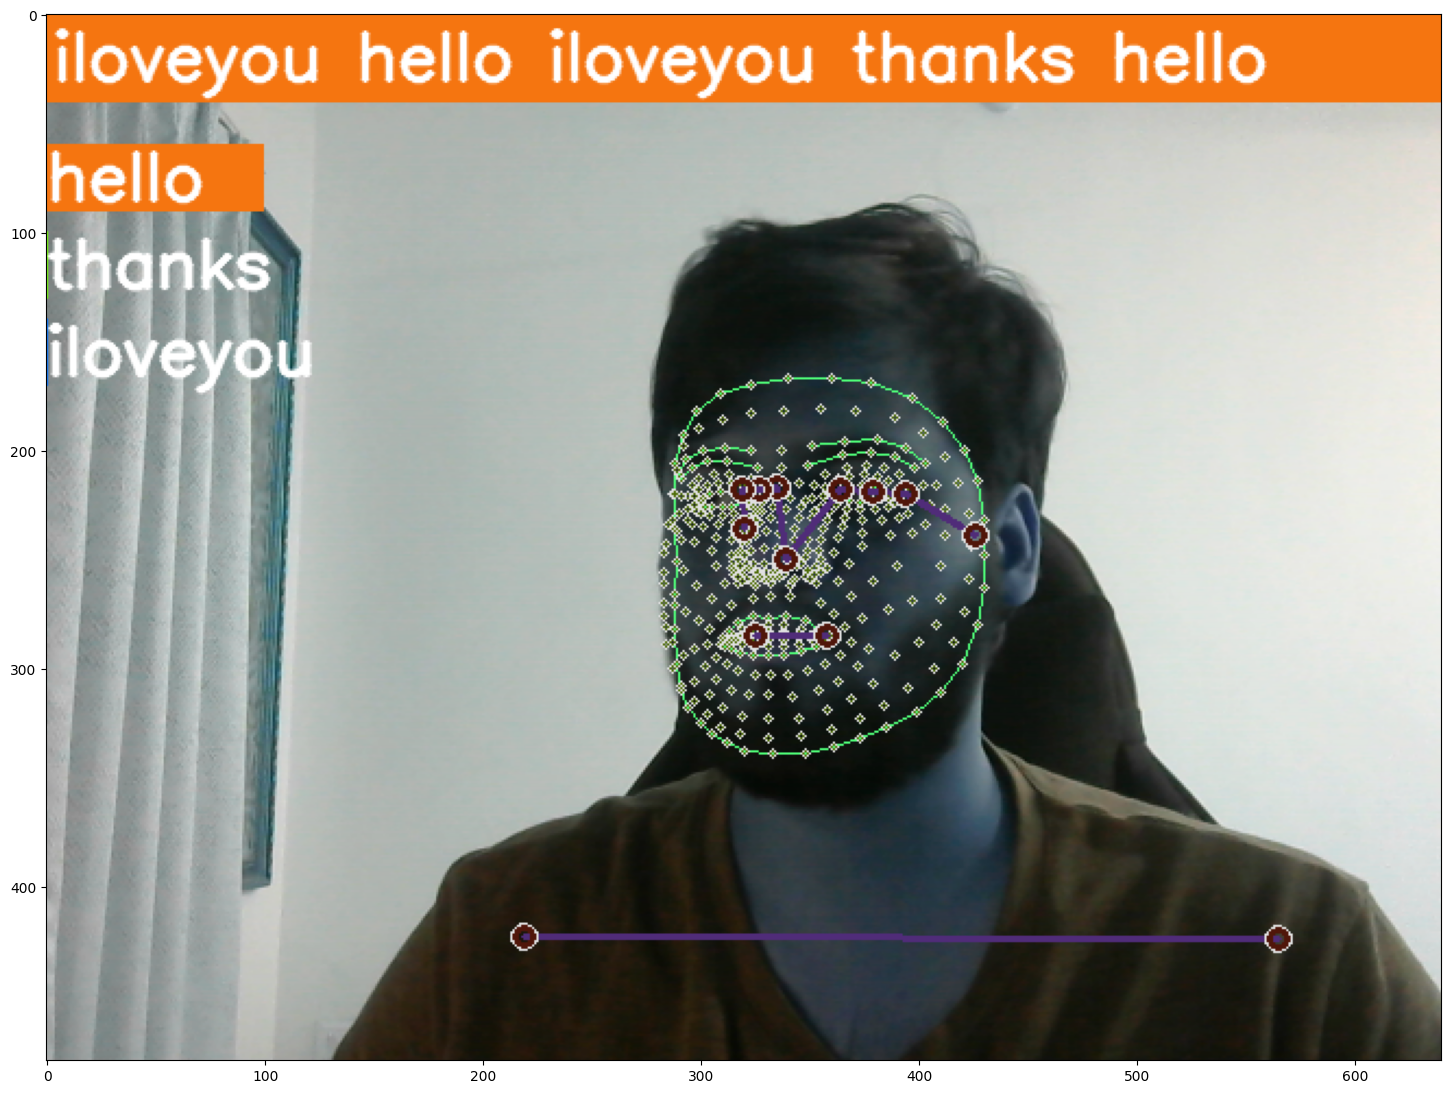

In [47]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))